# MadMiner particle physics tutorial

# Part 3a: Training a likelihood ratio estimator

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 3a of this tutorial we will finally train a neural network to estimate likelihood ratios. We assume that you have run part 1 and 2a of this tutorial. If, instead of 2a, you have run part 2b, you just have to load a different filename later.

## Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator



In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [3]:
# sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
sampler = SampleAugmenter('/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/delphes_data_shuffled.h5')

14:47 madminer.analysis.da INFO    Loading data from /data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/delphes_data_shuffled.h5
14:47 madminer.analysis.da INFO    Found 2 parameters
14:47 madminer.analysis.da INFO    Did not find nuisance parameters
14:47 madminer.analysis.da INFO    Found 6 benchmarks, of which 6 physical
14:47 madminer.analysis.da INFO    Found 18 observables
14:47 madminer.analysis.da INFO    Found 89591 events
14:47 madminer.analysis.da INFO      34607 signal events sampled from benchmark sm
14:47 madminer.analysis.da INFO      17041 signal events sampled from benchmark w
14:47 madminer.analysis.da INFO      15914 signal events sampled from benchmark neg_w
14:47 madminer.analysis.da INFO      11005 signal events sampled from benchmark ww
14:47 madminer.analysis.da INFO      11024 signal events sampled from benchmark neg_ww
14:47 madminer.analysis.da INFO    Found morphing setup with 6 components
14:47 madminer.analysis.da INFO    Did not find nuisance morphing setup


The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `sample_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `sample_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `sample_train_density()` for neural density estimation techniques like MAF or SCANDAL;
- `sample_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `sample_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `sample_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `benchmark()`, `benchmarks()`, `morphing_point()`, `morphing_points()`, and `random_morphing_points()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the ALICES method, so we focus on the `extract_samples_train_ratio()` function. We'll sample the numerator hypothesis in the likelihood ratio with 1000 points drawn from a Gaussian prior, and fix the denominator hypothesis to the SM.

Note the keyword `sample_only_from_closest_benchmark=True`, which makes sure that for each parameter point we only use the events that were originally (in MG) generated from the closest benchmark. This reduces the statistical fluctuations in the outcome quite a bit.

In [5]:
x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler.sample_train_ratio(
    #theta0=sampling.random_morphing_points(1000, [('gaussian', 0., 5), ('gaussian', 0., 5)]),
    theta0=sampling.random_morphing_points(1000, [('gaussian', 0., 0.5), ('gaussian', 0., 0.5)]),
    theta1=sampling.benchmark('sm'),
    n_samples=1000000,
    folder='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples',
    filename='train_ratio',
    sample_only_from_closest_benchmark=True,
    return_individual_n_effective=True,
)

16:14 madminer.sampling.sa INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: 1000 random morphing points, drawn from the following priors:
  theta_0 ~ Gaussian with mean 0.0 and std 0.5
  theta_1 ~ Gaussian with mean 0.0 and std 0.5, denominator hypothesis: sm
16:14 madminer.sampling.sa INFO    Starting sampling serially
16:14 madminer.sampling.sa WARNING Large statistical uncertainty on the total cross section when sampling from theta = [0.6102509  0.17949708]: (0.000003 +/- 0.000001) pb (39.53561175954016 %). Skipping these warnings in the future...
16:14 madminer.sampling.sa INFO    Sampling from parameter point 50 / 1000
16:15 madminer.sampling.sa INFO    Sampling from parameter point 100 / 1000
16:15 madminer.sampling.sa INFO    Sampling from parameter point 150 / 1000
16:16 madminer.sampling.sa INFO    Sampling from parameter point 200 / 1000
16:16 madminer.sampling.sa INFO    Sampling from parameter point 250 / 1000
16:16 madminer.sampling.sa INFO

For the evaluation we'll need a test sample:

In [6]:
_ = sampler.sample_test(
    theta=sampling.benchmark('sm'),
    n_samples=1000,
    folder='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples',
    filename='test'
)

18:10 madminer.sampling.sa INFO    Extracting evaluation sample. Sampling according to sm
18:10 madminer.sampling.sa INFO    Starting sampling serially
18:10 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
18:10 madminer.sampling.sa INFO    Effective number of samples: mean 6898.000000000001, with individual thetas ranging from 6898.000000000002 to 6898.000000000002


In [6]:
_,_,neff=sampler.sample_train_plain(
    theta=sampling.morphing_point([0,0.5]),
    n_samples=10000,
)

19:01 madminer.sampling.sa INFO    Extracting plain training sample. Sampling according to [0.  0.5]
19:01 madminer.sampling.sa INFO    Starting sampling serially
19:01 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
19:01 madminer.sampling.sa WARNING Large statistical uncertainty on the total cross section when sampling from theta = [0.  0.5]: (0.000004 +/- 0.000002) pb (41.715011589275385 %). Skipping these warnings in the future...
19:01 madminer.sampling.sa INFO    Effective number of samples: mean 129.83661780828058, with individual thetas ranging from 129.83661780828055 to 129.83661780828055


You might notice the information about the "eeffective number of samples" in the output. This is defined as `1 / max_events(weights)`; the smaller it is, the bigger the statistical fluctuations from too large weights. Let's plot this over the parameter space:

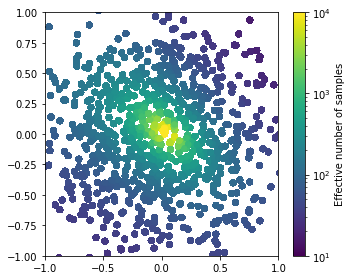

In [7]:
cmin, cmax = 10., 10000.

cut = (y.flatten()==0)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(theta0[cut][:,0], theta0[cut][:,1], c=n_effective[cut],
                 s=30., cmap='viridis',
                 norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
                 marker='o')

cb = plt.colorbar(sc)
cb.set_label('Effective number of samples')

plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.tight_layout()
plt.show()

## 2. Plot cross section over parameter space

This is not strictly necessary, but we can also plot the cross section as a function of parameter space:

In [8]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sampler.cross_sections(
    theta=sampling.benchmarks(list(sampler.benchmarks.keys()))
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sampler.cross_sections(
    #theta=sampling.random_morphing_points(1000, [('gaussian', 0., 5), ('gaussian', 0., 5)])
    theta=sampling.random_morphing_points(1000, [('gaussian', 0., 0.5), ('gaussian', 0., 0.5)])
)

18:12 madminer.sampling.sa INFO    Starting cross-section calculation
18:12 madminer.sampling.sa INFO    Starting cross-section calculation


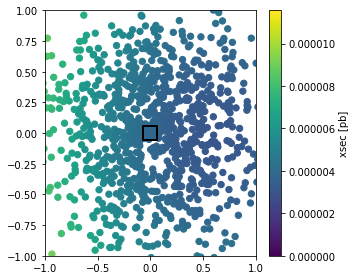

In [9]:
cmin, cmax = 0., 2.5 * np.mean(xsecs_morphing)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=cmin, vmax=cmax,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=cmin, vmax=cmax, lw=2., edgecolor='black',
            marker='s')

cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-1.,1.)
plt.ylim(-1.,1.)
plt.tight_layout()
plt.show()

What  you see here is a morphing algorithm in action. We only asked MadGraph to calculate event weights (differential cross sections, or basically squared matrix elements) at six fixed parameter points (shown here as squares with black edges). But with our knowledge about the structure of the process we can interpolate any observable to any parameter point without loss (except that statistical uncertainties might increase)!

## 3. Train likelihood ratio estimator

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.ParameterizedRatioEstimator` class. It defines functions that train, save, load, and evaluate the estimators.

In the initialization, the keywords `n_hidden` and `activation` define the architecture of the (fully connected) neural network:

In [10]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(60,60),
    activation="tanh",
)

To train this model we will minimize the ALICES loss function described in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973). Many alternatives, including RASCAL, are described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). There is also SCANDAL introduced in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244).

In [11]:
estimator.train(
    method='alices',
    theta='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/theta0_train_ratio.npy',
    x='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/x_train_ratio.npy',
    y='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/y_train_ratio.npy',
    r_xz='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/r_xz_train_ratio.npy',
    t_xz='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/t_xz_train_ratio.npy',
    alpha=10,
    n_epochs=10,
    scale_parameters=True,
)

estimator.save('/data_CMS/cms/cortinovis/ewdim6/models_ew_1M_az/alices')

17:12 madminer.ml.paramete INFO    Starting training
17:12 madminer.ml.paramete INFO      Method:                 alices
17:12 madminer.ml.paramete INFO      alpha:                  10
17:12 madminer.ml.paramete INFO      Batch size:             128
17:12 madminer.ml.paramete INFO      Optimizer:              amsgrad
17:12 madminer.ml.paramete INFO      Epochs:                 10
17:12 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
17:12 madminer.ml.paramete INFO      Validation split:       0.25
17:12 madminer.ml.paramete INFO      Early stopping:         True
17:12 madminer.ml.paramete INFO      Scale inputs:           True
17:12 madminer.ml.paramete INFO      Scale parameters:       True
17:12 madminer.ml.paramete INFO      Shuffle labels          False
17:12 madminer.ml.paramete INFO      Samples:                all
17:12 madminer.ml.paramete INFO    Loading training data
17:12 madminer.utils.vario INFO      Loading /data_CMS/cms/cortinov

Let's for fun also train a model that only used `pt_j1` as input observable, which can be specified using the option `features` when defining the `ParameterizedRatioEstimator`

## 4. Evaluate likelihood ratio estimator

`estimator.evaluate_log_likelihood_ratio(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood ratio and 25\*100 estimates for the score, both indexed by `[i_theta,i_x]`.

In [6]:
#theta_each = np.linspace(-10,10,25)
theta_each = np.linspace(-1.,1.,25)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/theta_ref.npy', theta_denom)


In [7]:
estimator.load('/data_CMS/cms/cortinovis/ewdim6/models_ew_1M_az/alices')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/theta_grid.npy',
    x='/data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/x_test.npy',
    evaluate_score=False
)

16:59 madminer.ml.base     INFO    Loading model from /data_CMS/cms/cortinovis/ewdim6/models_ew_1M_az/alices
16:59 madminer.utils.vario INFO      Loading /data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/x_test.npy into RAM
16:59 madminer.utils.vario INFO      Loading /data_CMS/cms/cortinovis/ewdim6/data_ew_1M_az/samples/theta_grid.npy into RAM


Let's look at the result:

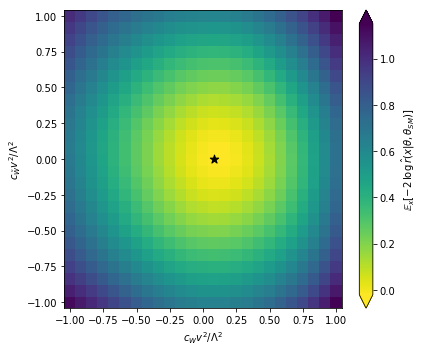

In [13]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((25,25)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$c_{W} v^2 / \Lambda^2$')
plt.ylabel(r'$c_{\tilde{W}} v^2 / \Lambda^2$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.savefig("alices_val.pdf")
plt.show()


Note that in this tutorial our sample size was very small, and the network might not really have a chance to converge to the correct likelihood ratio function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!